<h1>Importing libraries and loading dataset</h1>

In [1]:
!pip install bioinfokit

In [2]:
!pip install scikit_posthocs

In [3]:
!pip install pingouin

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.factorplots import interaction_plot
import scikit_posthocs as sp
from bioinfokit.analys import stat


In [5]:
df = pd.read_csv('diabetes.csv')

df.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [6]:
#summary statistics of the initial dataset

df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

<h3>Data cleaning</h3>

In [7]:
#how many 0s do we have in each column?

cols_all = df.columns.to_list()
#print(cols_all)

num_zeroes = pd.DataFrame({'Column':[],'Number of 0s':[]})

for col in cols_all:
    num_zeroes = num_zeroes.append(
        {'Column':col,'Number of 0s':(df[col]==0).sum()}
        ,ignore_index=True
        )
    
num_zeroes

Column  Number of 0s
0               Pregnancies         111.0
1                   Glucose           5.0
2             BloodPressure          35.0
3             SkinThickness         227.0
4                   Insulin         374.0
5                       BMI          11.0
6  DiabetesPedigreeFunction           0.0
7                       Age           0.0
8                   Outcome         500.0

In [8]:
#replace those 0s with the mean for columns that physically cannot be 0

zero_cols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in zero_cols:
    df.loc[df[col]==0,col]=df[col].mean()
    
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000        0  33.6   
1            1     85.0           66.0      29.000000        0  26.6   
2            8    183.0           64.0      20.536458        0  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

We're going to limit the analysis to certain variables: BloodPressure (quantitative dependent variable of interest), Age, Outcome, Pregnancies, Glucose, BMI.


Reasons: They're more easily interpertable and relatable, and have health implications outside just diabetes.

In [9]:
cols_selected = ['BloodPressure','Pregnancies','Glucose','BMI','Age','Outcome',]
df = df[cols_selected]
df.head(5)

BloodPressure  Pregnancies  Glucose   BMI  Age  Outcome
0           72.0            6    148.0  33.6   50        1
1           66.0            1     85.0  26.6   31        0
2           64.0            8    183.0  23.3   32        1
3           66.0            1     89.0  28.1   21        0
4           40.0            0    137.0  43.1   33        1

In [10]:
#binning age into groups:

labels= ['20 to 29','30 to 39','40 to 49','50 to 59','60+']

df['Age_bin'] = pd.cut(df['Age'],
                       bins=[20,30,40,50,60,max(df['Age'])],
                       labels=labels)
                        
#df.head()

pd.DataFrame(df['Age_bin'].value_counts())

Age_bin
20 to 29      417
30 to 39      157
40 to 49      113
50 to 59       54
60+            27

In [11]:
#summary statistics after cleaning

df.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  \
count     768.000000   768.000000  768.000000  768.000000  768.000000   
mean       72.254807     3.845052  121.681605   32.450805   33.240885   
std        12.115932     3.369578   30.436016    6.875374   11.760232   
min        24.000000     0.000000   44.000000   18.200000   21.000000   
25%        64.000000     1.000000   99.750000   27.500000   24.000000   
50%        72.000000     3.000000  117.000000   32.000000   29.000000   
75%        80.000000     6.000000  140.250000   36.600000   41.000000   
max       122.000000    17.000000  199.000000   67.100000   81.000000   

          Outcome  
count  768.000000  
mean     0.348958  
std      0.476951  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

<h1>Exploratory Data Analysis</h1>

In [12]:
sns.set_theme(style='whitegrid',palette='bright')

In [13]:
pd.crosstab(df.Age_bin, df.Outcome,margins=True)

Outcome     0    1  All
Age_bin                
20 to 29  327   90  417
30 to 39   81   76  157
40 to 49   49   64  113
50 to 59   23   31   54
60+        20    7   27
All       500  268  768

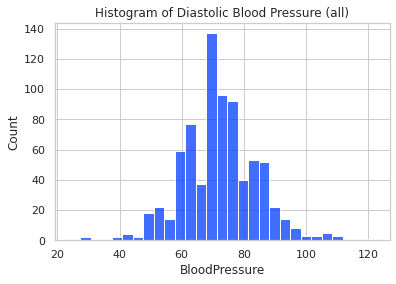

In [14]:
#histogram of blood pressure

sns.histplot(data=df,x='BloodPressure')
plt.title('Histogram of Diastolic Blood Pressure (all)')
plt.show()

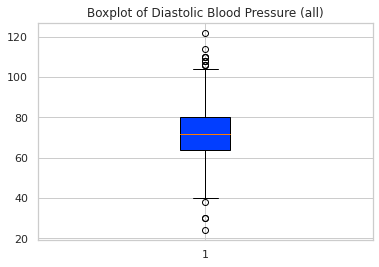

In [15]:
#boxplot of BP
#in matplotlib because apparently seaborn doesn't like vert boxplots
#with only one axis

plt.boxplot(data=df,x='BloodPressure',patch_artist=True)
plt.title('Boxplot of Diastolic Blood Pressure (all)')
plt.show()

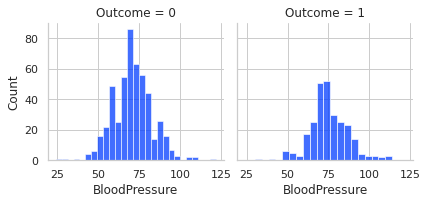

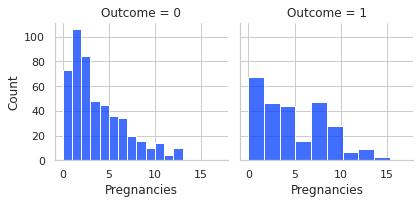

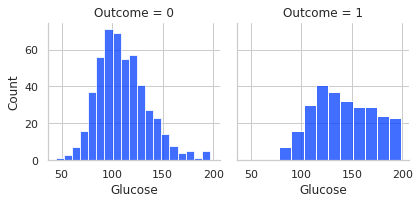

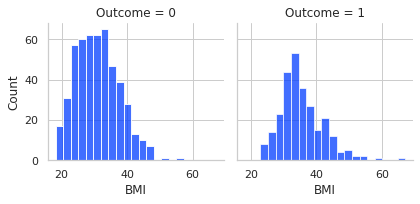

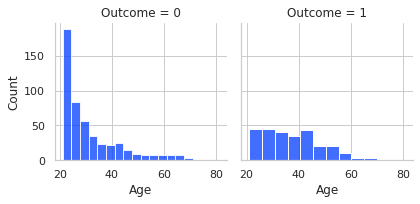

In [16]:
#and histograms of the others in case there's anything interesting

for col in cols_selected[:-1]:
    g = sns.FacetGrid(data=df,col='Outcome',margin_titles=True)
    g.map(sns.histplot,col)
    plt.show()

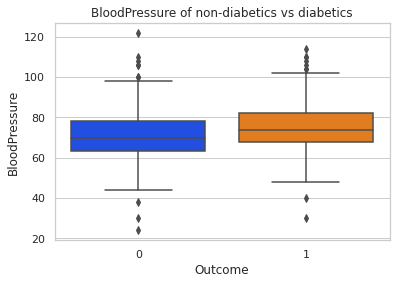

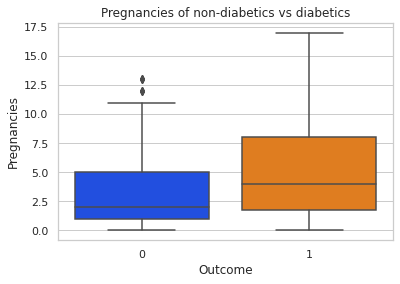

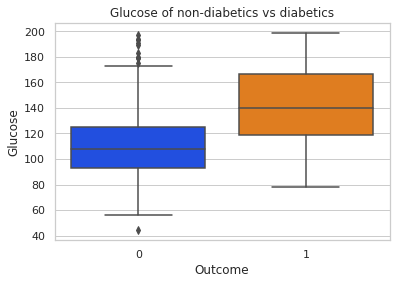

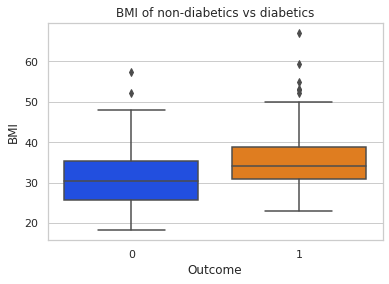

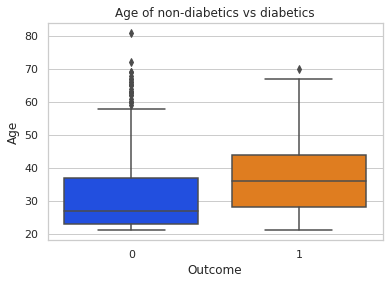

In [17]:
#boxplots of BP and other variables

for col in cols_selected[:-1]:
    sns.boxplot(data=df,x='Outcome',y=col)
    plt.title(f'{col} of non-diabetics vs diabetics')
    plt.show()

<h3>EDA for blood pressure across age categories<h/3>

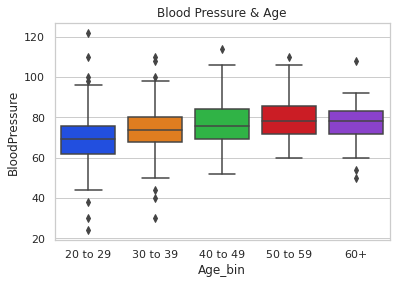

In [18]:
#blood pressure and age categories

sns.boxplot(data=df,x='Age_bin',y='BloodPressure')
plt.title('Blood Pressure & Age')

plt.show()

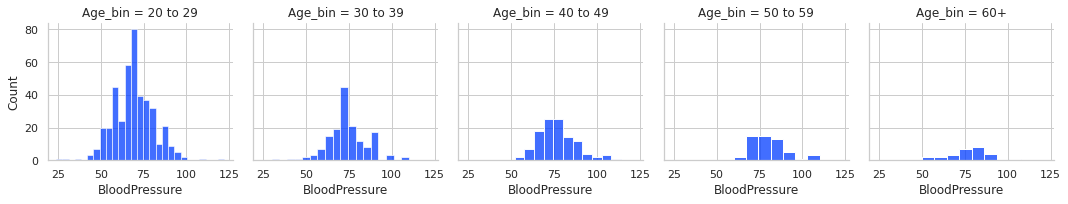

In [19]:
g = sns.FacetGrid(data=df,col='Age_bin',margin_titles=True)
g.map(sns.histplot,'BloodPressure')
plt.show()

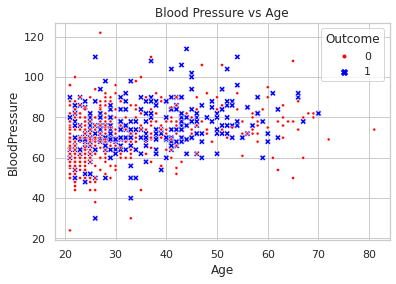

In [20]:
#quick scatterplot to look at the relationship of age and BP...

m = {0:'.',1:'X'}
sns.scatterplot(
    data=df,x='Age',y='BloodPressure',hue='Outcome',style='Outcome',
    markers=m,palette=['red','blue']
    )
plt.title('Blood Pressure vs Age')
plt.show()


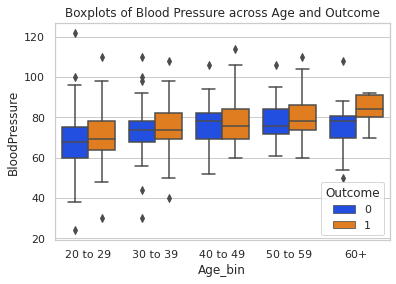

In [21]:
#and then some box and violin plots

sns.boxplot(
    data=df, x="Age_bin", y="BloodPressure", hue='Outcome'
    )
plt.title('Boxplots of Blood Pressure across Age and Outcome')
plt.show()

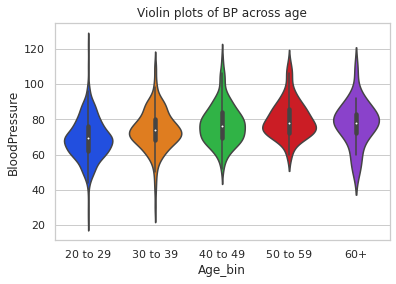

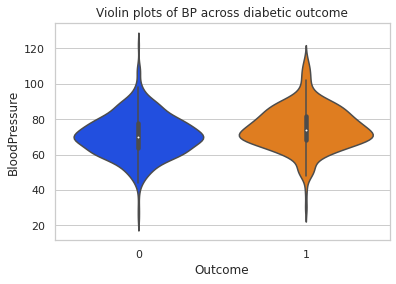

In [22]:
#categories separately, then together in split violin below

ax = sns.violinplot(data=df,x='Age_bin',y='BloodPressure')
plt.title('Violin plots of BP across age')
plt.show()

ax = sns.violinplot(data=df,x='Outcome',y='BloodPressure')
plt.title('Violin plots of BP across diabetic outcome')
plt.show()

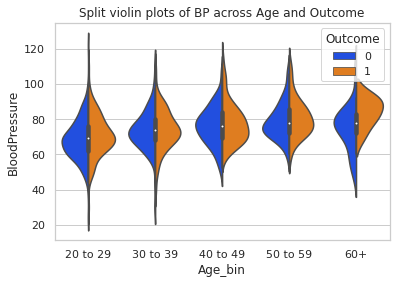

In [23]:
sns.violinplot(data=df,x='Age_bin',y='BloodPressure',hue='Outcome',split=True)
plt.title('Split violin plots of BP across Age and Outcome')
plt.show()

Testing normality and constancy of variance (we'll get to testing these assumptions for residuals later too)

In [24]:
#normality:

w, pvalue = stats.shapiro(df['BloodPressure'])
print(f'w={w}, p-value={pvalue}')

w=0.9878163933753967, p-value=5.254140432953136e-06


In [25]:
#constancy of variance across outcome cats:

w, pvalue = stats.levene(
    df.loc[df['Outcome']==0]['BloodPressure'],
    df.loc[df['Outcome']==1]['BloodPressure']
    )

print(f'w={w}, p-value={pvalue}')

w=0.00017964008680908006, p-value=0.9893097729572887


In [26]:
#across age bins:
#I'm sure I can do this with a for loop but can't be bothered right now

w, pvalue = stats.levene(
    df.loc[df['Age_bin']=='20 to 29']['BloodPressure'],
    df.loc[df['Age_bin']=='30 to 39']['BloodPressure'],
    df.loc[df['Age_bin']=='40 to 49']['BloodPressure'],
    df.loc[df['Age_bin']=='50 to 59']['BloodPressure'],
    df.loc[df['Age_bin']=='60+']['BloodPressure'],
    )

print(f'w={w}, p-value={pvalue}')

w=0.3435869928418082, p-value=0.8485438676545106


These suggest blood pressure is not normally distributed, but variance is constant across outcome and age groups.

In [27]:
#just to be sure we get the same result with bioinfokit...

x = stat()
x.levene(df=df,res_var='BloodPressure',xfac_var='Age_bin')
x.levene_summary


Parameter   Value
0      Test statistics (W)  0.3436
1  Degrees of freedom (Df)  4.0000
2                  p value  0.8485

<h2>T-tests</h2>

H_0: BP is the same between outcome categories (diabetic and non-diabetic)

H_1: BP is different between outcomes

In [28]:
#first let's split the data to make it easier

df_0 = df[df['Outcome']==0]
df_1 = df[df['Outcome']==1]


In [29]:
df_0.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  Outcome
count     500.000000   500.000000  500.000000  500.000000  500.000000    500.0
mean       70.810008     3.298000  110.705367   30.880066   31.190000      0.0
std        11.932269     3.017185   24.715021    6.503051   11.667655      0.0
min        24.000000     0.000000   44.000000   18.200000   21.000000      0.0
25%        63.500000     1.000000   93.000000   25.750000   23.000000      0.0
50%        70.000000     2.000000  107.500000   30.400000   27.000000      0.0
75%        78.000000     5.000000  125.000000   35.300000   37.000000      0.0
max       122.000000    13.000000  197.000000   57.300000   81.000000      0.0

In [30]:
df_1.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  Outcome
count     268.000000   268.000000  268.000000  268.000000  268.000000    268.0
mean       74.950326     4.865672  142.159661   35.381288   37.067164      1.0
std        12.016572     3.741239   29.545943    6.596733   10.968254      0.0
min        30.000000     0.000000   78.000000   22.900000   21.000000      1.0
25%        68.000000     1.750000  119.000000   30.900000   28.000000      1.0
50%        74.000000     4.000000  140.000000   34.250000   36.000000      1.0
75%        82.000000     8.000000  167.000000   38.775000   44.000000      1.0
max       114.000000    17.000000  199.000000   67.100000   70.000000      1.0

In [31]:
#to summarize BP, our outcome variable, for diabetics vs non-diabetics:

pd.DataFrame({
    '0 (non-diabetic)':df_0['BloodPressure'].describe(),
    '1 (diabetic)':df_1['BloodPressure'].describe(),
    })

0 (non-diabetic)  1 (diabetic)
count        500.000000    268.000000
mean          70.810008     74.950326
std           11.932269     12.016572
min           24.000000     30.000000
25%           63.500000     68.000000
50%           70.000000     74.000000
75%           78.000000     82.000000
max          122.000000    114.000000

In [32]:
#and summary stats of BP across age bins

pd.DataFrame({
    agebin:df[df['Age_bin']==agebin]['BloodPressure'].describe() 
    for agebin in labels
    })

20 to 29    30 to 39    40 to 49    50 to 59         60+
count  417.000000  157.000000  113.000000   54.000000   27.000000
mean    68.969593   73.795183   77.233822   80.055556   77.596499
std     11.701913   11.432092   11.158403   10.298226   12.314339
min     24.000000   30.000000   52.000000   60.000000   50.000000
25%     62.000000   68.000000   69.105469   72.000000   72.000000
50%     69.105469   74.000000   76.000000   78.000000   78.000000
75%     76.000000   80.000000   84.000000   85.750000   83.000000
max    122.000000  110.000000  114.000000  110.000000  108.000000

In [33]:
#now let's try t-tests for each one

ttest_results = pd.DataFrame({'Variable':[],'t-statistic':[],'p-value':[]})

for col in cols_selected[:-1]:
    tStat, pValue = stats.ttest_ind(df_0[col],df_1[col],equal_var=False)
    ttest_results = ttest_results.append(
        {'Variable':col,'t-statistic':tStat,'p-value':pValue},
        ignore_index=True
    )
    
ttest_results

Variable  t-statistic       p-value
0  BloodPressure    -4.562334  6.260424e-06
1    Pregnancies    -5.906961  6.821926e-09
2        Glucose   -14.862435  3.163533e-41
3            BMI    -9.057760  2.435552e-18
4            Age    -6.920738  1.201513e-11

From simple t-tests, all of these appear statistically significant (p-value < 0.05)

Graphing distribution of BP:

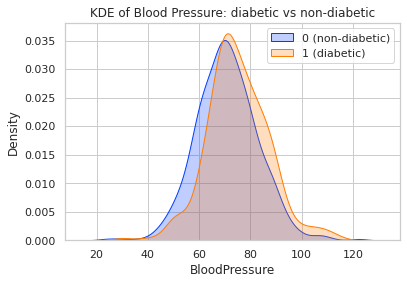

In [34]:
sns.kdeplot(data=df_0['BloodPressure'],shade=True)
sns.kdeplot(data=df_1['BloodPressure'],shade=True)
plt.title('KDE of Blood Pressure: diabetic vs non-diabetic')
plt.legend(['0 (non-diabetic)','1 (diabetic)'])
plt.show()

Other quantitative variables just to see:

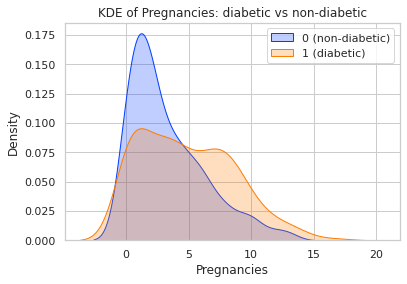

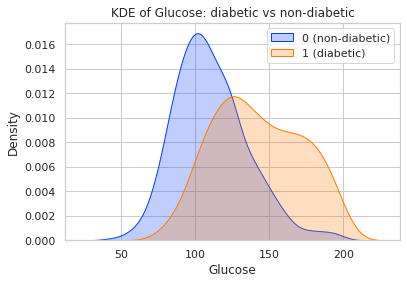

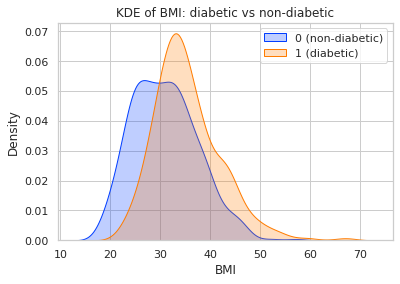

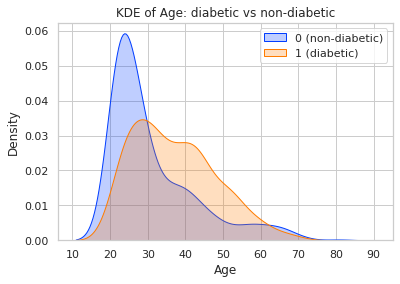

In [35]:
for col in cols_selected[1:-1]:
    sns.kdeplot(data=df_0[col],shade=True)
    sns.kdeplot(data=df_1[col],shade=True)
    plt.title(f'KDE of {col}: diabetic vs non-diabetic')
    plt.legend(['0 (non-diabetic)','1 (diabetic)'])
    plt.show()
    
    

<h2>Linear Regressions</h2>

<h3>Simple linear regression (BP vs Age)</h3>

In [36]:
x = df['Age'].values.reshape(-1,1)
y = df['BloodPressure']

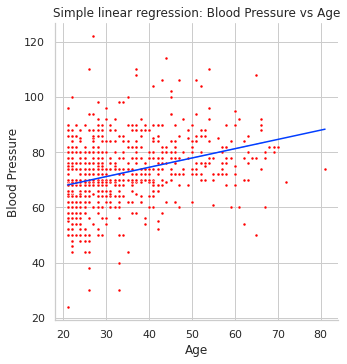

In [37]:
lr_model = LinearRegression()
lr_model.fit(x, y)
y_pred = lr_model.predict(x)

sns.relplot(x=df['Age'],y=y_pred,kind='line')
sns.scatterplot(
    x=df['Age'],y=df['BloodPressure'],color='red',marker='.'
    )
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.title('Simple linear regression: Blood Pressure vs Age')
plt.show()

In [38]:
print(f'Coefficient: {lr_model.coef_[0]}')
print(f'intercept: {lr_model.intercept_}')
print(f'R^2 score: {lr_model.score(x,y)}')

Coefficient: 0.33662282904929053
intercept: 61.06516562949305
R^2 score: 0.1067591851504931


In [39]:
#same ols again in scipy because it includes p-value

res = stats.linregress(x=df['Age'],y=df['BloodPressure'])

print(f'coeff: {res.slope}')
print(f'intercept: {res.intercept}')
print(f'p-value: {res.pvalue}')
print(f'r^2: {res.rvalue**2}')
print(f'std err: {res.stderr}')

coeff: 0.33662282904929103
intercept: 61.06516562949304
p-value: 1.4515438152916903e-20
r^2: 0.10675918515049326
std err: 0.035181215095340154


In [40]:
#viewing the residuals

df_lr_pred = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
df_lr_pred.head(10)

Actual  Predicted
0  72.000000  77.896307
1  66.000000  71.500473
2  64.000000  71.837096
3  66.000000  68.134245
4  40.000000  72.173719
5  74.000000  71.163851
6  50.000000  69.817359
7  69.105469  70.827228
8  70.000000  78.906176
9  96.000000  79.242798

In [41]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 8.66906499953217
Mean Squared Error: 130.95326428961815
Root Mean Squared Error: 11.443481301143379


Text(0.5, 1.0, 'Residuals of simple linear regression')

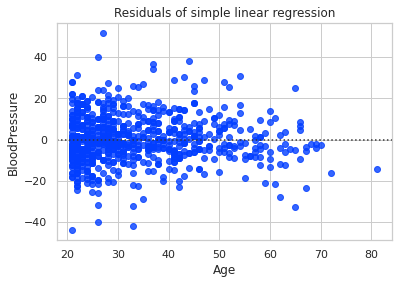

In [42]:
#plotting the residuals to see their distribution...

sns.residplot(data=df,x='Age',y='BloodPressure')
plt.title('Residuals of simple linear regression')

The shape of the residual plot shows variance is a lot higher among lower ages; we'll explore this more when doing ANOVA.

Now, what happens if we try to run separate regressions on people with and without diabetes?

In [43]:
x_diab = df_1['Age'].values.reshape(-1,1)
y_diab = df_1['BloodPressure']

x_ndiab = df_0['Age'].values.reshape(-1,1)
y_ndiab = df_0['BloodPressure']

In [44]:
lr_model_diab = LinearRegression()
lr_model_diab.fit(x_diab, y_diab)
y_pred_diab = lr_model_diab.predict(x_diab)

lr_model_ndiab = LinearRegression()
lr_model_ndiab.fit(x_ndiab, y_ndiab)
y_pred_ndiab = lr_model_ndiab.predict(x_ndiab)

In [45]:
print('People with diabetes:')
print(f'Coefficient: {lr_model_diab.coef_[0]}')
print(f'intercept: {lr_model_diab.intercept_}')
print(f'R^2 score: {lr_model_diab.score(x,y)}')

print('\nPeople without diabetes:')
print(f'Coefficient: {lr_model_ndiab.coef_[0]}')
print(f'intercept: {lr_model_ndiab.intercept_}')
print(f'R^2 score: {lr_model_ndiab.score(x,y)}\n')

People with diabetes:
Coefficient: 0.32308086244414164
intercept: 62.97463512119364
R^2 score: 0.0920601166582472

People without diabetes:
Coefficient: 0.3103909310897683
intercept: 61.12891467181013
R^2 score: 0.10165520204604106



In [46]:
##in scipy again bc built-in p-values!!

res_0 = stats.linregress(x=df_0['Age'],y=df_0['BloodPressure'])

print('Simple LR on people without diabetes:\n',
    res_0)

res_1 = stats.linregress(x=df_1['Age'],y=df_1['BloodPressure'])

print('\nSimple LR on people with diabetes:\n',
    res_1)

Simple LR on people without diabetes:
 LinregressResult(slope=0.3103909310897683, intercept=61.12891467181013, rvalue=0.3035075826324537, pvalue=4.094680823906528e-12, stderr=0.04366563537171635, intercept_stderr=1.4539266555179455)

Simple LR on people with diabetes:
 LinregressResult(slope=0.32308086244414147, intercept=62.97463512119365, rvalue=0.29489548680202915, pvalue=8.88675651205884e-07, stderr=0.06418689907915436, intercept_stderr=2.480828513832322)


We can seee that along with similar R^2, the slopes and intercepts are quite similar, which can also be shown graphically...

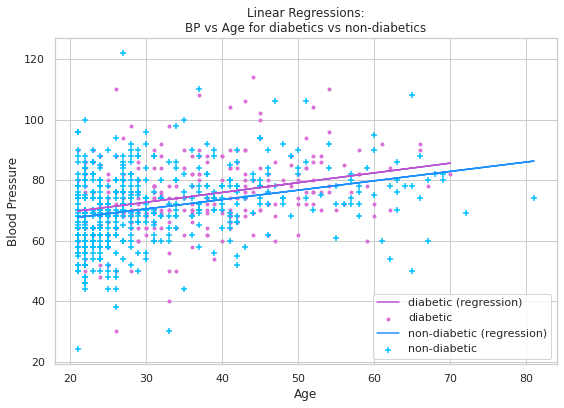

In [47]:
#yes I know there's a function for this in seaborn already
#this is here anyway to make sure I understand which line means what

plt.figure(figsize=(9,6))
plt.plot(df_1['Age'],y_pred_diab,color='#BA55D3')
plt.scatter(
    df_1['Age'],df_1['BloodPressure'],color='orchid',marker='.'
    )
plt.plot(df_0['Age'],y_pred_ndiab,color='#1E90FF')
plt.scatter(
    x=df_0['Age'],y=df_0['BloodPressure'],color='#00BFFF',marker='+'
    )
plt.legend(
    ['diabetic (regression)',
     'diabetic',
     'non-diabetic (regression)',
     'non-diabetic'])
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.title('Linear Regressions:\nBP vs Age for diabetics vs non-diabetics')
plt.show()

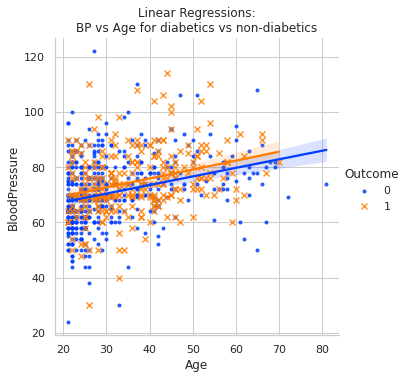

In [48]:
sns.lmplot(
    data=df,x='Age',y='BloodPressure',markers=['.','x'],hue='Outcome'
    )
plt.title('Linear Regressions:\nBP vs Age for diabetics vs non-diabetics')
plt.show()

<h3>Multiple Linear Regression</h3>

In [49]:
#categories to use for MLR

predict_cats = ['Pregnancies','Glucose','BMI','Age','Outcome']

x_mult = df[predict_cats]
y_mult = df['BloodPressure']

In [50]:
mult_lr = LinearRegression()
mult_lr.fit(x_mult,y_mult)

LinearRegression()

In [51]:
print(f'Coefficients: {mult_lr.coef_}')
print(f'intercept: {mult_lr.intercept_}')
print(f'R^2 score: {mult_lr.score(x_mult,y_mult)}')

Coefficients: [ 0.17962621  0.04029814  0.46539779  0.28520246 -1.17986589]
intercept: 42.4894010676046
R^2 score: 0.18983072411900337


In [52]:
y_pred_mult = mult_lr.predict(x_mult)

df_2 = pd.DataFrame({
    'Age': df['Age'],
    'Actual': y_mult,
    'Predicted': y_pred_mult,
    'Residual': y_mult - y_pred_mult})
df_2.head()

Age  Actual  Predicted   Residual
0   50    72.0  78.248906  -6.248906
1   31    66.0  67.315226  -1.315226
2   32    64.0  70.091351  -6.091351
3   21    66.0  65.322491   0.677509
4   33    40.0  76.300706 -36.300706

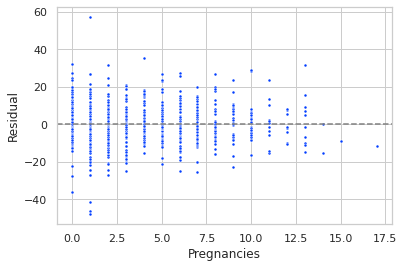

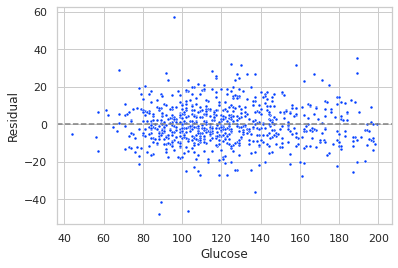

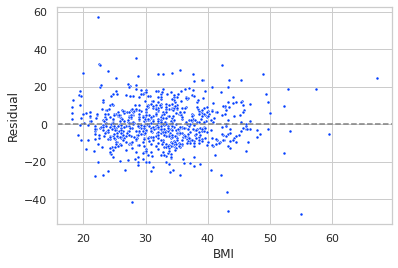

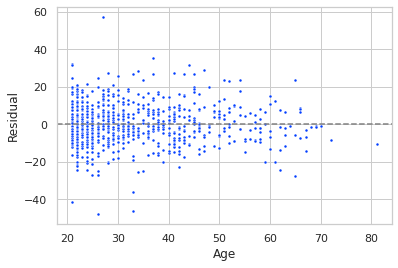

In [53]:
#plotting the residuals against the individual (quantitative) predictor cats

for cat in predict_cats[:-1]: #not outcome
    ax = sns.scatterplot(x=df[cat],y=df_2['Residual'],marker='.')
    plt.axhline(y=0, color='gray',linestyle="--")
    plt.show()

These all look fairly evenly dispersed—more so than age, at least...

In [54]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_mult, y_pred_mult))
print('Mean Squared Error:', metrics.mean_squared_error(y_mult, y_pred_mult))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mult, y_pred_mult)))

Mean Absolute Error: 8.269676817503415
Mean Squared Error: 118.7745897187283
Root Mean Squared Error: 10.898375554124032


Now let's try using ANOVA to compare the blood pressure of different groups
of people (with and w/o diabetes, and of different age groups)

<h1>ANOVA</h1>

In [55]:
# #one-way: BP, 'outcome' as categorical

model_diab = ols('BloodPressure ~ C(Outcome)', data=df).fit()
anova_table = sm.stats.anova_lm(model_diab, typ=2)
anova_table

sum_sq     df          F    PR(>F)
C(Outcome)    2990.963536    1.0  20.903727  0.000006
Residual    109601.413909  766.0        NaN       NaN

In [56]:
#and then done again with bioinfokit to make sure numbers are the same

res_d = stat()
res_d.anova_stat(
    df=df,res_var='BloodPressure',
    anova_model='BloodPressure ~ C(Outcome)'
    )
res_d.anova_summary

df         sum_sq      mean_sq          F    PR(>F)
C(Outcome)    1.0    2990.963536  2990.963536  20.903727  0.000006
Residual    766.0  109601.413909   143.082786        NaN       NaN

In [57]:
import pingouin as pg

In [58]:
#tukey HSD test for effect size

pairwise_diabetes=pg.pairwise_tukey(
    data=df,dv='BloodPressure', between='Outcome', effsize = 'cohen',
)

pairwise_diabetes

A  B    mean(A)    mean(B)      diff       se         T   p-tukey     cohen
0  0  1  70.810008  74.950326 -4.140319  0.90557 -4.572059  0.000006 -0.346131

In [59]:
#I've also calculated cohen's d for this manually
#partly just to make sure I know how...

stdev0 = np.var(df.loc[df['Outcome']==0]['BloodPressure'])
stdev1 = np.var(df.loc[df['Outcome']==1]['BloodPressure'])

mean0 = np.mean(df.loc[df['Outcome']==0]['BloodPressure'])
mean1 = np.mean(df.loc[df['Outcome']==1]['BloodPressure'])

cohen = (mean0-mean1)/np.sqrt((stdev0+stdev1)/2)
cohen

-0.3462589922223039

In [60]:
#one-way anova with age as categorical variable

res_a = stat()
res_a.anova_stat(
    df=df,res_var='BloodPressure',anova_model='BloodPressure ~ C(Age_bin)'
    )
res_a.anova_summary

df         sum_sq      mean_sq          F        PR(>F)
C(Age_bin)    4.0   11730.786383  2932.696596  22.185328  2.403381e-17
Residual    763.0  100861.591062   132.190814        NaN           NaN

In [61]:
#tukey HSD with cohen's d

pairwise_age=pg.pairwise_tukey(
    data=df,dv='BloodPressure', between='Age_bin', effsize = 'cohen'
    )

pairwise_age.head()

A         B    mean(A)    mean(B)       diff        se         T  \
0  20 to 29  30 to 39  68.969593  73.795183  -4.825590  1.076561 -4.482411   
1  20 to 29  40 to 49  68.969593  77.233822  -8.264229  1.219358 -6.777523   
2  20 to 29  50 to 59  68.969593  80.055556 -11.085962  1.662824 -6.666950   
3  20 to 29       60+  68.969593  77.596499  -8.626906  2.283191 -3.778443   
4  30 to 39  40 to 49  73.795183  77.233822  -3.438639  1.418383 -2.424338   

        p-tukey     cohen  
0  8.316475e-05 -0.419710  
1  2.447705e-10 -0.718789  
2  5.009053e-10 -0.964213  
3  1.592777e-03 -0.750334  
4  1.099245e-01 -0.299079

In [62]:
#filtering for significance at alpha = 0.05

pairwise_age.query('`p-tukey` < 0.05')

A         B    mean(A)    mean(B)       diff        se         T  \
0  20 to 29  30 to 39  68.969593  73.795183  -4.825590  1.076561 -4.482411   
1  20 to 29  40 to 49  68.969593  77.233822  -8.264229  1.219358 -6.777523   
2  20 to 29  50 to 59  68.969593  80.055556 -11.085962  1.662824 -6.666950   
3  20 to 29       60+  68.969593  77.596499  -8.626906  2.283191 -3.778443   
5  30 to 39  50 to 59  73.795183  80.055556  -6.260372  1.813824 -3.451477   

        p-tukey     cohen  
0  8.316475e-05 -0.419710  
1  2.447705e-10 -0.718789  
2  5.009053e-10 -0.964213  
3  1.592777e-03 -0.750334  
5  5.310871e-03 -0.544502

<h3>Testing assumptions of normality and constancy of variance</h3>

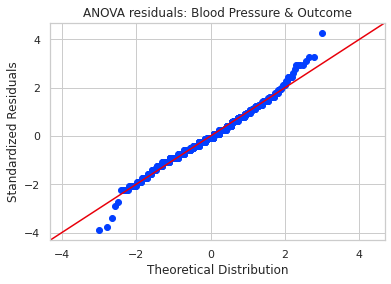

In [63]:
sm.qqplot(res_d.anova_std_residuals,line='45')
plt.xlabel("Theoretical Distribution")
plt.ylabel("Standardized Residuals")
plt.title('ANOVA residuals: Blood Pressure & Outcome')
plt.show()

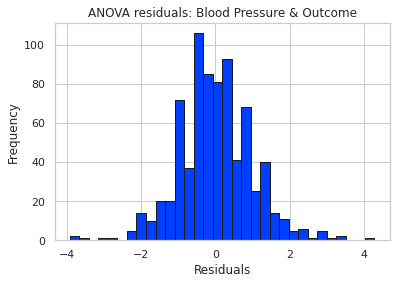

In [64]:
plt.hist(res_d.anova_std_residuals, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel("Frequency")
plt.title('ANOVA residuals: Blood Pressure & Outcome')
plt.show()

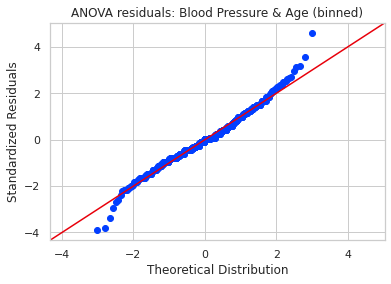

In [65]:
sm.qqplot(res_a.anova_std_residuals,line='45')
plt.xlabel("Theoretical Distribution")
plt.ylabel("Standardized Residuals")
plt.title('ANOVA residuals: Blood Pressure & Age (binned)')
plt.show()

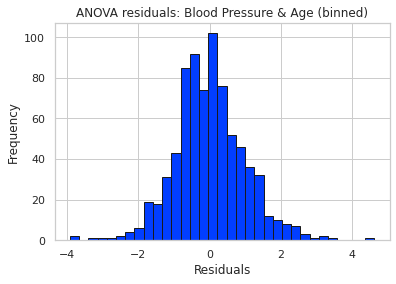

In [66]:
plt.hist(res_a.anova_std_residuals, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel("Frequency")
plt.title('ANOVA residuals: Blood Pressure & Age (binned)')
plt.show()

In [67]:
#shapiro-wilks test for normality

w_d, pvalue_d = stats.shapiro(res_d.anova_model_out.resid)
print(w_d, pvalue_d)


0.9879077076911926 5.719261480408022e-06


In [68]:
w_a, pvalue_a = stats.shapiro(res_a.anova_model_out.resid)
print(w_a, pvalue_a)

0.9857938885688782 8.651253438074491e-07


The very low p-values for both mean we can reject the null hypothesis; the data is not normally distributed, as we can see from those fat tails in QQ and histogram plots.

In [69]:
#Levene's test for homogeneity of variance

res_d.levene(df=df,res_var='BloodPressure',xfac_var='Outcome')
res_d.levene_summary

Parameter   Value
0      Test statistics (W)  0.0002
1  Degrees of freedom (Df)  1.0000
2                  p value  0.9893

In [70]:
res_a.levene(df=df,res_var='BloodPressure',xfac_var='Age_bin')
res_a.levene_summary

Parameter   Value
0      Test statistics (W)  0.3436
1  Degrees of freedom (Df)  4.0000
2                  p value  0.8485

P-value > 0.05 for both tests, so the assumption of homongeneity of variance stands.

<h3>Two-way ANOVA<h3)

In [71]:
#may need to convert age_bin to numerical values to do interaction plot
#because statsmodels doesn't seem to like my categorical labels...
#i swear it works half the time but can't figure out why
#run these lines if needed


df.replace(labels,np.arange(len(labels)),inplace=True)

In [72]:
df['Age_bin'].replace(np.arange(len(labels)),labels,inplace=True)

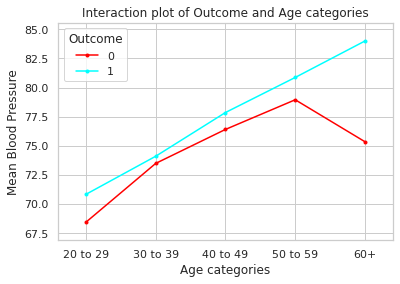

In [73]:
#interaction plot

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['BloodPressure']
    )
plt.xlabel('Age categories')
plt.ylabel('Mean Blood Pressure')
plt.title('Interaction plot of Outcome and Age categories')
plt.show()

In [74]:
#anova with categorical variables age + outcome, and interaction effect

res_2 = stat()
res_2.anova_stat(
    df=df, res_var='Outcome', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.anova_summary

df        sum_sq      mean_sq          F  \
C(Outcome)               1.0    589.292533   589.292533   4.469101   
C(Age_bin)               4.0   9329.115380  2332.278845  17.687633   
C(Outcome):C(Age_bin)    4.0    322.949809    80.737452   0.612300   
Residual               758.0  99949.348719   131.859299        NaN   

                             PR(>F)  
C(Outcome)             3.483915e-02  
C(Age_bin)             6.841729e-14  
C(Outcome):C(Age_bin)  6.538853e-01  
Residual                        NaN

From this it looks like there is a statistically significant difference for both of our main effects, yet not our interaction effect.

Still, let's do some posthoc tests...

In [75]:
#This one's unnecessary bc with only two categories we know which comparison is interesting
#nevertheless we'll leave this line of code here

res_2 = stat()
res_2.tukey_hsd(
    df=df, res_var='Glucose', xfac_var='Outcome', 
    anova_model='Glucose ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.tukey_summary


/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1  group2       Diff      Lower      Upper    q-value  p-value
0       1       0  31.454293  27.575842  35.332745  22.515348    0.001

In [76]:
#posthoc test on the age category

res_2 = stat()
res_2.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var='Age_bin', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1    group2       Diff     Lower      Upper   q-value   p-value
1  40 to 49  20 to 29   8.264229  4.934247  11.594210  9.596907  0.001000
4  30 to 39  20 to 29   4.825590  1.885577   7.765603  6.347050  0.001000
5  30 to 39  50 to 59   6.260372  1.306947  11.213798  4.887258  0.005232
7  20 to 29  50 to 59  11.085962  6.544909  15.627016  9.440336  0.001000
8  20 to 29       60+   8.626906  2.391673  14.862139  5.350238  0.001563

In [77]:
res_2 = stat()
res_2.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var=['Outcome','Age_bin'], 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1         group2       Diff     Lower      Upper   q-value  \
1   (1, 40 to 49)  (1, 20 to 29)   7.018791  1.060773  12.976809  5.286555   
6   (1, 40 to 49)  (0, 20 to 29)   9.408937  4.428388  14.389485  8.477653   
14  (1, 30 to 39)  (0, 20 to 29)   5.658468  1.018398  10.298538  5.472511   
17  (1, 20 to 29)  (1, 50 to 59)  10.027088  2.438809  17.615366  5.929852   
27  (1, 50 to 59)  (0, 20 to 29)  12.417234  5.569616  19.264851  8.137625   
32       (1, 60+)  (0, 20 to 29)  15.546266  1.627427  29.465105  5.012280   
36  (0, 40 to 49)  (0, 20 to 29)   7.958734  2.376929  13.540539  6.398550   
39  (0, 30 to 39)  (0, 20 to 29)   5.043999  0.521626   9.566372  5.005194   
42  (0, 20 to 29)  (0, 50 to 59)  10.502788  2.642310  18.363265  5.996088   

     p-value  
1   0.007581  
6   0.001000  
14  0.004627  
17  0.001266  
27  0.001000  
32  0.015149  
36  0.001000  
39  0.015412  
42  0.001040

In [78]:
# #all results from the above

# res_2.tukey_summary

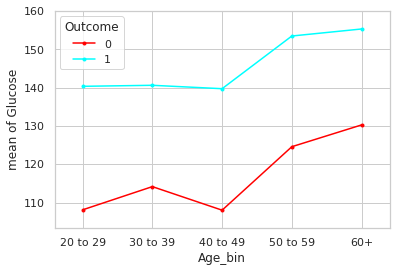

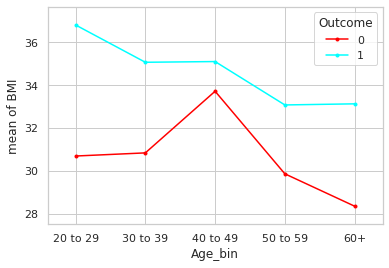

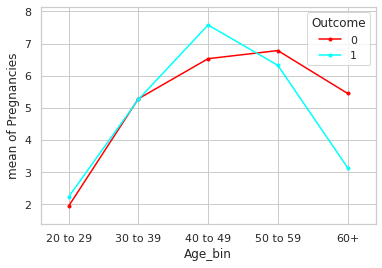

In [79]:
#drawing interaction plots for glucose, BMI, pregnancies as outcome vars
#just to see if there's anything interesting

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['Glucose']
    )
plt.show()

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['BMI']
    )
plt.show()

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['Pregnancies']
    )
plt.show()

Glucose is quite parallel, the others not so much.

Interestingly, the 40 to 49 category looks quite different here for both glucose and BMI, which is not seen in the interaction plot for blood pressure.

What's going on with pregnancies? Might be interesting to explore further at a later time.

Let's try re-running the BP outcome model as a purely additive model, no interaction effect...

In [80]:
#one more anova w/o interaction?

res_2a = stat()
res_2a.anova_stat(
    df=df, res_var='Outcome', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin)'
    )
res_2a.anova_summary

df         sum_sq      mean_sq          F        PR(>F)
C(Outcome)    1.0     589.292533   589.292533   4.478215  3.465325e-02
C(Age_bin)    4.0    9329.115380  2332.278845  17.723703  6.369900e-14
Residual    762.0  100272.298529   131.590943        NaN           NaN

In [81]:
#w/o interaction - posthoc test on outcome

res_2a = stat()
res_2a.tukey_hsd(
    df=df, res_var='Glucose', xfac_var='Outcome', 
    anova_model='Glucose ~ C(Outcome) + C(Age_bin)'
    )
res_2a.tukey_summary

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1  group2       Diff      Lower      Upper    q-value  p-value
0       1       0  31.454293  27.582064  35.326523  22.551337    0.001

In [82]:
#w/o interaction - posthoc test on age

res_2a = stat()
res_2a.tukey_hsd(
    df=df, res_var='Glucose', xfac_var='Age_bin', 
    anova_model='Glucose ~ C(Outcome) + C(Age_bin)'
    )
res_2a.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1    group2       Diff      Lower      Upper   q-value   p-value
1  40 to 49  20 to 29  10.910014   3.354303  18.465725  5.583612  0.001000
2  40 to 49  50 to 59  15.193329   3.407320  26.979338  4.984842  0.004095
4  30 to 39  20 to 29  11.903568   5.232694  18.574442  6.900168  0.001000
5  30 to 39  50 to 59  14.199775   2.960478  25.439073  4.885483  0.005253
7  20 to 29  50 to 59  26.103343  15.799715  36.406972  9.796505  0.001000
8  20 to 29       60+  21.695936   7.548224  35.843648  5.930037  0.001000

In [83]:
#w/o interaction - posthoc test on age and outcome pairings

res_2a = stat()
res_2a.tukey_hsd(
    df=df, res_var='Glucose', xfac_var=['Outcome','Age_bin'], 
    anova_model='Glucose ~ C(Outcome) + C(Age_bin)'
    )
res_2a.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1         group2       Diff      Lower      Upper    q-value  \
4   (1, 40 to 49)  (0, 40 to 49)  31.701477  16.007389  47.395566   9.064605   
5   (1, 40 to 49)  (0, 30 to 39)  25.553329  11.726060  39.380598   8.293093   
6   (1, 40 to 49)  (0, 20 to 29)  31.613760  20.312954  42.914566  12.553713   
12  (1, 30 to 39)  (0, 40 to 49)  32.590718  17.443423  47.738012   9.655268   
13  (1, 30 to 39)  (0, 30 to 39)  26.442569  13.239180  39.645959   8.987186   
14  (1, 30 to 39)  (0, 20 to 29)  32.503000  21.974736  43.031264  13.853904   
19  (1, 20 to 29)  (0, 40 to 49)  32.322222  17.644015  47.000429   9.881746   
20  (1, 20 to 29)  (0, 30 to 39)  26.174074  13.511582  38.836566   9.275933   
21  (1, 20 to 29)  (0, 20 to 29)  32.234505  22.393084  42.075926  14.698353   
25  (1, 50 to 59)  (0, 40 to 49)  45.451613  26.477957  64.425268  10.749884   
26  (1, 50 to 59)  (0, 30 to 39)  39.303465  21.842407  56.764523  10.101032   
27  (1, 50 to 59)  (0, 20 to 29)  45.363895  29.826734  60.901057  13.102197   
28  (1, 50 to 59)  (0, 50 to 59)  28.886396   6.133482  51.639309   5.697205   
30       (1, 60+)  (0, 40 to 49)  47.285714  13.879147  80.692282   6.351899   
31       (1, 60+)  (0, 30 to 39)  41.137566   8.566295  73.708837   5.667733   
32       (1, 60+)  (0, 20 to 29)  47.197997  15.616316  78.779678   6.706467   
38  (0, 40 to 49)       (0, 60+)  22.250000   0.312031  44.187969   4.551338   
43  (0, 20 to 29)       (0, 60+)  22.162283   3.118169  41.206396   5.222269   

     p-value  
4   0.001000  
5   0.001000  
6   0.001000  
12  0.001000  
13  0.001000  
14  0.001000  
19  0.001000  
20  0.001000  
21  0.001000  
25  0.001000  
26  0.001000  
27  0.001000  
28  0.002482  
30  0.001000  
31  0.002696  
32  0.001000  
38  0.043706  
43  0.008949

Finally, let's check normality and variance, and plot the residuals (for the original 2-way ANOVA, with interaction)

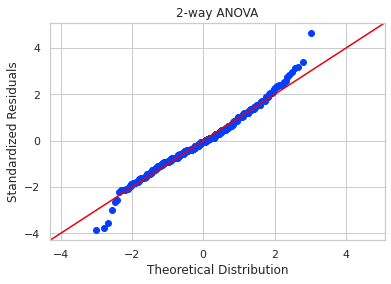

In [84]:
sm.qqplot(res_2.anova_std_residuals,line='45')
plt.xlabel("Theoretical Distribution")
plt.ylabel("Standardized Residuals")
plt.title('2-way ANOVA')
plt.show()

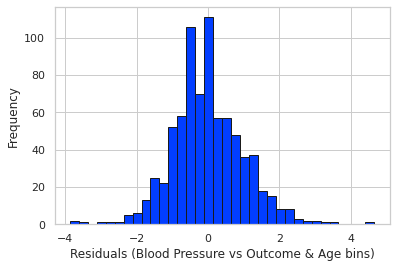

In [85]:
plt.hist(res_2.anova_std_residuals, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals (Blood Pressure vs Outcome & Age bins)")
plt.ylabel("Frequency")
plt.show()

In [86]:
w_d, pvalue_d = stats.shapiro(res_2.anova_model_out.resid)
print(w_d, pvalue_d)

0.985619068145752 7.449830263794865e-07


In [87]:
res_d.levene(df=df,res_var='BloodPressure',xfac_var=['Outcome','Age_bin'])
res_d.levene_summary

Parameter   Value
0      Test statistics (W)  0.2418
1  Degrees of freedom (Df)  9.0000
2                  p value  0.9882

In [ ]:
#sorry if I have bad taste in colour palettes :D